## High-GC-content windows explain the bias in the Chen model for B > 0.9

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

GC_WINDOW_SIZE = 100000

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd
from functools import reduce

def get_windows_with_GC_content_and_cpg_islands(): 
  df1 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
    sep='\t', 
  )

  df2 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.GC_content_{GC_WINDOW_SIZE}.bed', 
    sep='\t', 
  )
  df2 = df2[['chen_chrom', 'chen_start', 'chen_end', 'window_GC_content']]
  df2 = df2.rename(columns={
    'chen_chrom': 'chrom', 
    'chen_start': 'start', 
    'chen_end': 'end',
    'window_GC_content': f'GC_content_{GC_WINDOW_SIZE}bp'
  })

  # created using: experiments/germline-model/chen-et-al-2022/cpg-island-enrichment.ipynb
  df3 = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon-cpgIsland.bed',
    sep='\t', 
  )
  df3 = df3[['chromosome', 'start', 'end', 'cpg_island overlap', 'window overlaps cpg_island']]
  df3 = df3.rename(columns={
    'chromosome': 'chrom', 
    'cpg_island overlap': 'cpg_island_overlap', 
    'window overlaps cpg_island': 'window_overlaps_cpg_island'
  })

  dfs = [df1, df2, df3]
  df = reduce(lambda left, right: pd.merge(left, right, on=['chrom', 'start', 'end'], how='inner'), dfs)

  df = df[df['window overlaps enhancer'] == False]

  return df

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,...,log10_paternal_recombination_rate,log10_maternal_recombination_rate,B_M1star.EUR,B0_M3starHMT6.EUR,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_100000bp,cpg_island_overlap,window_overlaps_cpg_island
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.572894,NaN,False
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.572564,NaN,False
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.570774,NaN,False
5,chr1,1467000,1468000,2.958469,326.453703,273,False,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.583014,NaN,False
6,chr1,1476000,1477000,-0.662737,289.719448,301,False,False,0.651,0.039046,...,-1.408422,-1.587499,0.108103,0.057741,0.513191,0.105518,2.585568,0.582994,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019141,chr9,137136000,137137000,3.277688,316.292417,258,False,False,0.555,0.150095,...,-0.823635,-2.268173,0.165515,0.135944,3.636507,0.219258,2.281162,0.588594,NaN,False
1019142,chr9,137137000,137138000,2.779895,302.336307,254,False,False,0.555,14.102295,...,1.149290,0.230147,0.165515,0.135944,3.636507,0.219258,2.281162,0.587014,NaN,False
1019143,chr9,137138000,137139000,3.286597,273.337005,219,False,False,0.556,0.150095,...,-0.823635,-2.268173,0.165515,0.135944,3.636507,0.219258,2.281162,0.588514,217.0,True
1019144,chr9,137146000,137147000,6.685589,364.670293,237,False,False,0.556,0.004152,...,-2.381710,-3.603883,0.165515,0.135944,3.636507,0.219258,2.281162,0.600204,116.0,True


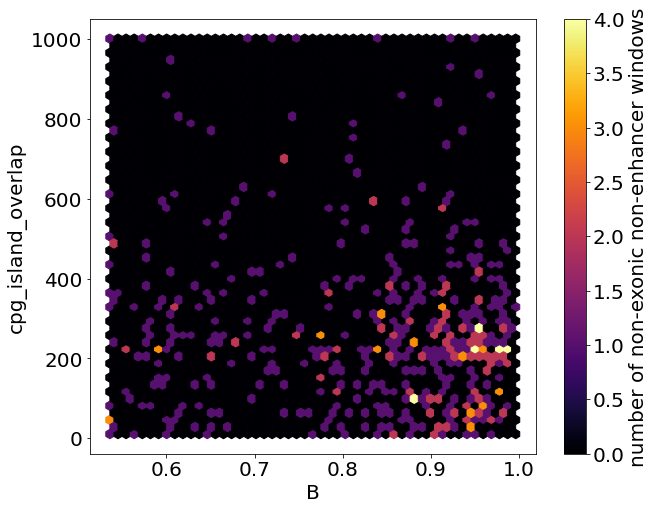

In [4]:
# CpG islands are too rare to explain N_observed < N_expected when B > 0.9 

plt.rcParams.update({
  'font.size': 20,
})

def correlate_cpg_island_overlap_vs_B(df, ylim=None):
  plt.figure(figsize=(10, 8))  
  plt.hexbin(df['B'], df['cpg_island_overlap'], gridsize=50, cmap='inferno')
  plt.xlabel('B')
  plt.ylabel('cpg_island_overlap')
  plt.colorbar(label='number of non-exonic non-enhancer windows')
  plt.ylim(ylim)

correlate_cpg_island_overlap_vs_B(WINDOWS)

In [5]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

def fraction_below_diag_heat_map(df, x, y, min_windows=10):  
  df = df.copy()

  df['below_diag'] = df['N_observed'] < df['N_expected']

  plt.figure(figsize=(10, 8))  

  # Create a diverging colormap
  cmap = cm.get_cmap('seismic')  # Use cm.get_cmap instead of plt.get_cmap
  divnorm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

  plt.hexbin(
    df[x], 
    df[y], 
    C=df['below_diag'], 
    reduce_C_function=np.mean,
    gridsize=50, 
    cmap=cmap,
    norm=divnorm,
    mincnt=min_windows  # Minimum number of windows required for a hexbin to be displayed
  )

  plt.gca().set_facecolor(3*[0.9])  # Set the background color of the axis to a lighter shade of grey

  plt.xlabel(x)
  plt.ylabel(y)
  plt.colorbar(label='fraction_below_diag')

def window_count_heat_map(df, x, y, min_windows=0):
  plt.figure(figsize=(10, 8))  

  # Fit a line to the data
  df = df.dropna(subset=[y])  
  m, b = np.polyfit(df[x], df[y], 1)

  plt.hexbin(
    df[x], 
    df[y], 
    gridsize=50, 
    cmap='inferno',
    mincnt=min_windows  # Minimum number of windows required for a hexbin to be displayed
  )

  # Plot the line
  plt.plot(df[x], m*df[x] + b, color='red')

  plt.xlabel(x)
  plt.ylabel(y)
  plt.colorbar(label='number of non-exonic non-enhancer windows')


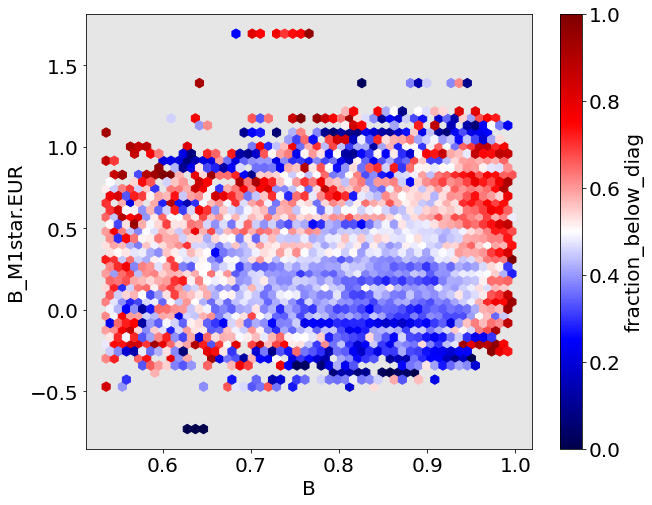

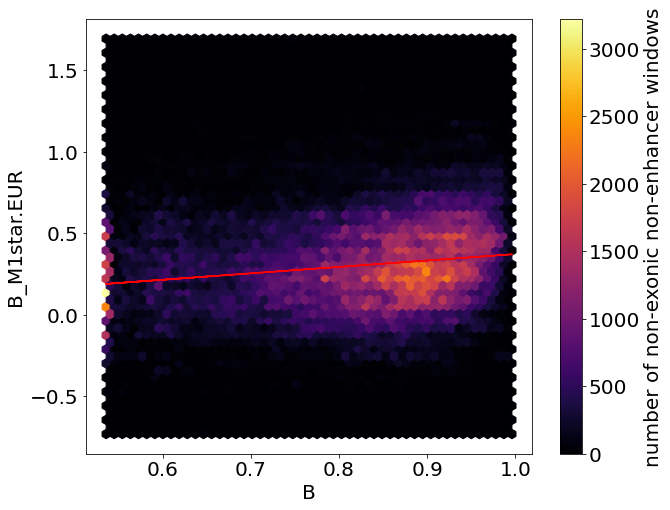

In [6]:
fraction_below_diag_heat_map(WINDOWS, x='B', y='B_M1star.EUR')  
window_count_heat_map(WINDOWS, x='B', y='B_M1star.EUR')

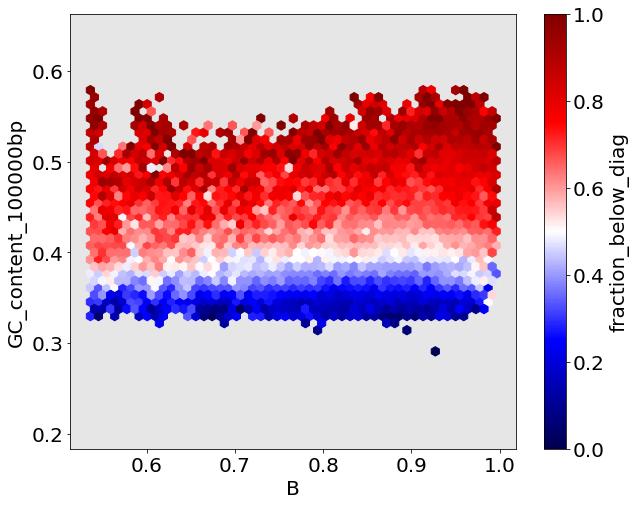

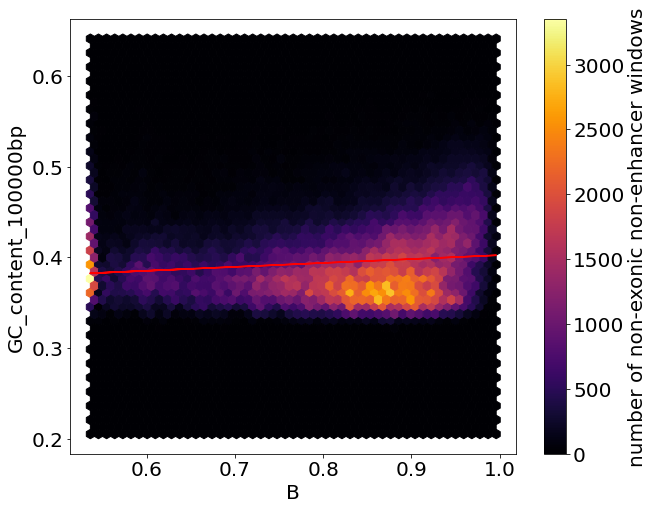

In [7]:
fraction_below_diag_heat_map(WINDOWS, x='B', y=f'GC_content_{GC_WINDOW_SIZE}bp')  
window_count_heat_map(WINDOWS, x='B', y=f'GC_content_{GC_WINDOW_SIZE}bp')

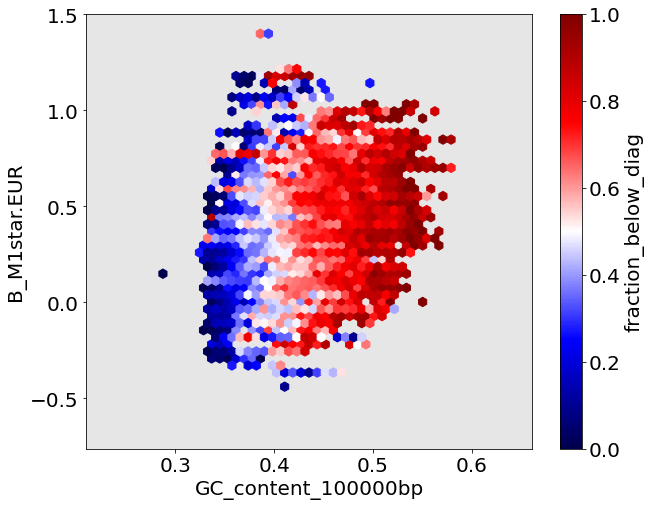

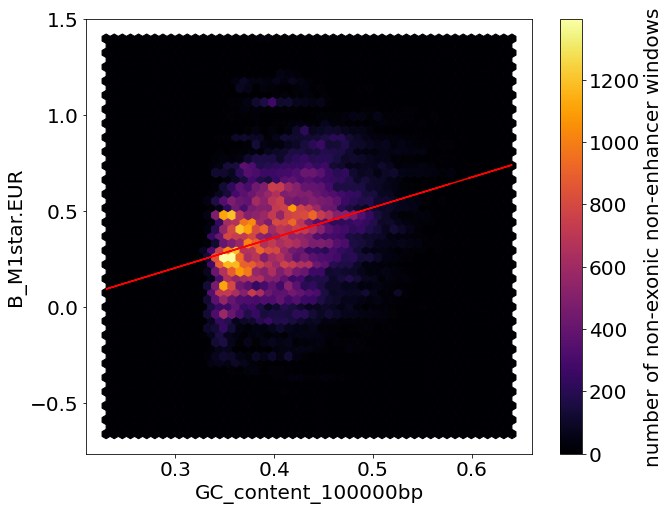

In [8]:
def get_high_B_windows(df): 
  return df[df['B'] > 0.9]

fraction_below_diag_heat_map(get_high_B_windows(WINDOWS), x=f'GC_content_{GC_WINDOW_SIZE}bp', y='B_M1star.EUR')  
window_count_heat_map(get_high_B_windows(WINDOWS), x=f'GC_content_{GC_WINDOW_SIZE}bp', y='B_M1star.EUR')